In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook
from pyha import *
from pyha.cores import *
from pyha.cores.util import *
import scipy
from scipy import signal
import warnings
warnings.filterwarnings('ignore') # yolo!
import numpy as np
import inspect
import matplotlib.pyplot as plt

def plot_window_freq_response(sims):
    def get_response(samples):
        A = np.fft.fft(samples, len(samples) * 8) / (len(samples)/2.0)
        freq = np.linspace(-1, 1, len(A))
        response = 20 * np.log10(np.abs(np.fft.fftshift(A / abs(A).max())))
        return freq, response
    
    plt.figure(figsize = (9.75, 5))
    plt.title('Frequency domain')
    plt.plot(*get_response(sims['MODEL']), label='MODEL')
    plt.plot(*get_response(sims['HARDWARE']), label='HARDWARE')

    plt.ylabel('Amplitude [dB]')
    plt.xlabel('Frequency')
    plt.ylim([-90, 1])
    show_plot()

# GitHub cannot display the Table of Contents!

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

# Info

In [11]:
print(inspect.getdoc(Windower))
print('\n\nMain interface\n' + inspect.getdoc(Windower.main))

Window function
---------------

Window function determines the frequency response of the FFT bins.

Args:
    window_length: Same as the FFT transform size.
    window (str): Name of the windowing function (imported from Scipy).
    coefficient_bits: Coefficients are stored as constants in LUTS.
        You will probably want to use the 8-bit 'hamming' window if the 'window_length' gets large.


Main interface
Args:
    input (DataValid): -1.0 ... 1.0 range, up to 18 bits

Returns:
    DataValid: Result rounded to 18 bits(-1.0 ... 1.0 range). Overflow impossible.


# Examples

In [4]:
window_length = 512

## Hamming 8-bit

INFO:sim:Tracing is enabled, running "MODEL" and "HARDWARE" simulations
INFO:sim:Running "MODEL" simulation...
INFO:sim:OK!
INFO:sim:Running "HARDWARE" simulation...


100%|██████████| 512/512 [00:00<00:00, 37855.80it/s]

INFO:sim:Flushing the pipeline to collect 512 valid samples (currently have 511)
INFO:sim:Flush took 1 cycles.
INFO:sim:OK!
INFO:sim:Simulations completed!


<IPython.core.display.Javascript object>


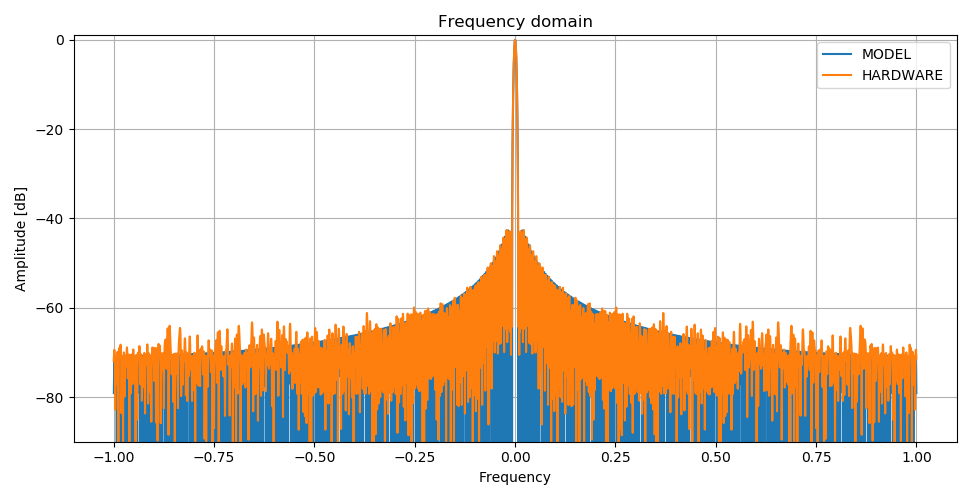

In [5]:
input_signal = [1.0 + 1.0j] * window_length
dut = Windower(window_length, window='hamming', coefficient_bits=8)
sims = simulate(dut, input_signal, trace=True, pipeline_flush='auto')
plot_window_freq_response(sims)

## Hanning 8-bit

INFO:sim:Tracing is enabled, running "MODEL" and "HARDWARE" simulations
INFO:sim:Running "MODEL" simulation...
INFO:sim:OK!
INFO:sim:Running "HARDWARE" simulation...


100%|██████████| 512/512 [00:00<00:00, 33662.78it/s]

INFO:sim:Flushing the pipeline to collect 512 valid samples (currently have 511)
INFO:sim:Flush took 1 cycles.
INFO:sim:OK!
INFO:sim:Simulations completed!


<IPython.core.display.Javascript object>


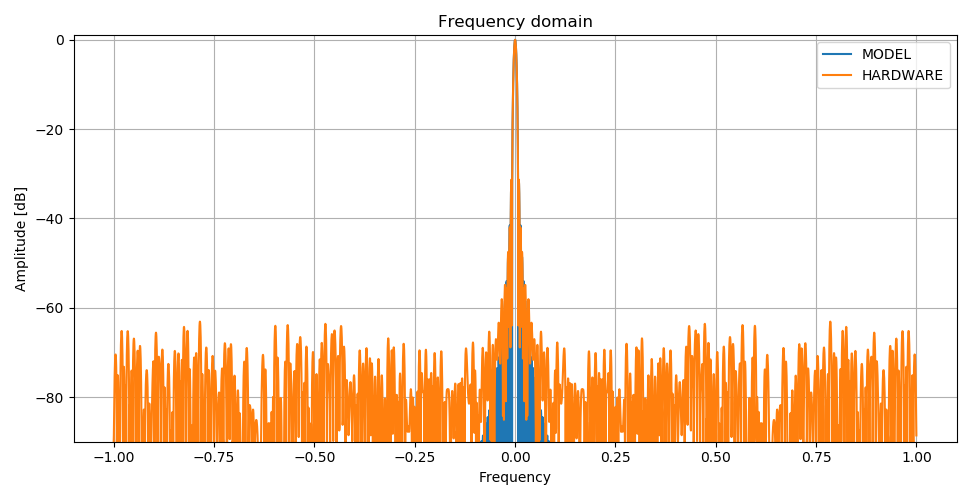

In [6]:
input_signal = [1.0 + 1.0j] * window_length
dut = Windower(window_length, window='hanning', coefficient_bits=8)
sims = simulate(dut, input_signal, trace=True, pipeline_flush='auto')
plot_window_freq_response(sims)

# Conversion to VHDL and RTL/NETLIST simulations

In [7]:
# Pyha supports running 'RTL' (using GHDL) and 'NETLIST' (netlist after quartus_map) level simulations.
output_dir = '~/Documents/pyha_output'
input_signal = np.random.normal(size=window_length) * 0.25
dut = Windower(window_length, window='hamming', coefficient_bits=8)
sims = simulate(dut, input_signal, pipeline_flush='auto', simulations=['MODEL', 'HARDWARE', 'RTL', 'NETLIST'], conversion_path=output_dir)

INFO:sim:Running "MODEL" simulation...
INFO:sim:OK!
INFO:sim:Simulaton needs to support conversion to VHDL -> major slowdown
INFO:sim:Running "HARDWARE" simulation...


100%|██████████| 512/512 [00:00<00:00, 10059.79it/s]

INFO:sim:Flushing the pipeline to collect 512 valid samples (currently have 511)
INFO:sim:Flush took 1 cycles.
INFO:sim:OK!
INFO:conversion:Creating top.vhd ...
INFO:conversion:DataValid to VHDL ...


INFO:conversion:Windower to VHDL ...
INFO:conversion:Took 0.10 seconds
INFO:sim:Running "RTL" simulation...
loading VPI module '/cocotb/build/libs/x86_64/libvpi.so'
VPI module loaded!
100%|##########| 513/513 [00:00<00:00, 3989.33it/s]

INFO:sim:OK!
INFO:sim:Running "NETLIST" simulation...
INFO:synth:Running quartus_map quartus_project...
INFO:synth:Running quartus_eda quartus_project...
loading VPI module '/cocotb/build/libs/x86_64/libvpi.so'
VPI module loaded!
100%|##########| 513/513 [00:00<00:00, 1637.54it/s]

INFO:sim:OK!
INFO:sim:Simulations completed!


# Synthesis:  resource usage and Fmax

In [8]:
quartus = get_simulator_quartus() # reuse the work that was done during the simulation
print(quartus.get_resource_usage('fit'))
print(quartus.get_fmax())

INFO:synth:Running quartus_fit quartus_project...
INFO:synth:Running quartus_sta -t script.tcl...


Family : Cyclone IV E
Device : EP4CE40F23C8
Timing Models : Final
Total logic elements : 269 / 39,600 ( < 1 % )
    Total combinational functions : 269 / 39,600 ( < 1 % )
    Dedicated logic registers : 53 / 39,600 ( < 1 % )
Total registers : 53
Total pins : 76 / 329 ( 23 % )
Total virtual pins : 0
Total memory bits : 0 / 1,161,216 ( 0 % )
Embedded Multiplier 9-bit elements : 4 / 232 ( 2 % )
Total PLLs : 0 / 4 ( 0 % )

+--------------------------------------------------+
; Fmax Summary                                     ;
+------------+-----------------+------------+------+
; Fmax       ; Restricted Fmax ; Clock Name ; Note ;
+------------+-----------------+------------+------+
; 104.85 MHz ; 104.85 MHz      ; clk        ;      ;
+------------+-----------------+------------+------+
This panel reports FMAX for every clock in the design, regardless of the user-specified clock periods.  FMAX is only computed for paths where the source and destination registers or ports are driven by the 